## Training a simple NN to identify particles in PID

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
import hist
import pyphysics as phys
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense

### Preparing the data

In [2]:
dfp = uproot.open("./Outputs/tree_11Li_2H_1H_Ex_0.00.root:SimulationTree").arrays(library="pd")
dfp = dfp.assign(label="p")
dfd = uproot.open("./Outputs/tree_11Li_2H_2H_Ex_0.00.root:SimulationTree").arrays(library="pd")
dfd = dfd.assign(label="d")
dft = uproot.open("./Outputs/tree_11Li_2H_3H_Ex_0.00.root:SimulationTree").arrays(library="pd")
dft = dft.assign(label="t")

dfs = pd.concat([dfp, dfd, dft], ignore_index=True)
dfs = dfs.sample(frac=1, random_state=42).reset_index(drop=True)
dfs = dfs[dfs["dE1"] > 0]
dfs.head()

,dEgas,dE0,dE1,T3,theta3,RPx,T3After1,label
0,0.228507,4.551895,7.955368,27.704399,10.691672,58.653112,14.918340,p
1,0.343325,6.732589,8.149758,27.524277,14.025612,26.058819,12.191230,p
2,0.009517,7.032139,11.362184,25.004331,19.179890,210.735162,6.590184,p
3,0.316498,7.978685,16.111431,24.451798,24.174533,108.955744,0.000000,p
5,0.189468,6.298465,7.489299,28.339591,6.795277,77.332281,14.350186,p


<BarContainer object of 3 artists>

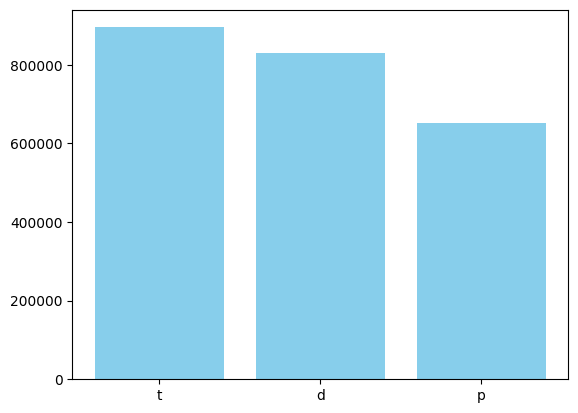

In [3]:
labels = dfs["label"].value_counts()
plt.bar(labels.index, labels.values, color="skyblue")

<BarContainer object of 3 artists>

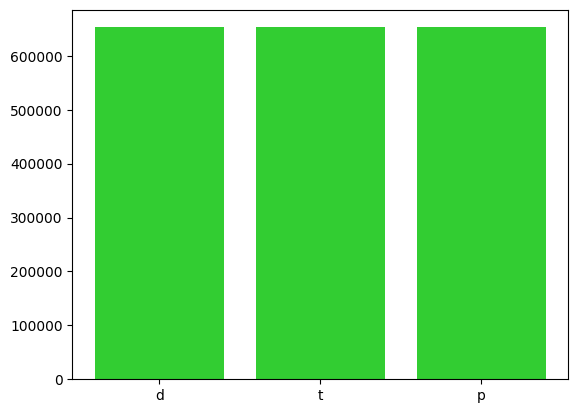

In [4]:
# Downsample so we have same counts for all clasess
minority = labels.idxmin()
df_minority = dfs[dfs["label"] == minority]
dfs_downsampled = [df_minority]
for label in labels.index:
    if label == minority: 
        continue
    aux = dfs[dfs["label"] == label]
    downsampled = aux.sample(len(df_minority), random_state=42)
    dfs_downsampled.append(downsampled)

dfs = pd.concat(dfs_downsampled)
dfs = dfs.sample(frac=1, random_state=42).reset_index(drop=True)

ok_labels= dfs["label"].value_counts()
plt.bar(ok_labels.index, ok_labels.values, color="limegreen")

Plotting the data we will train

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x751e9d6148b0>, cbar=<matplotlib.colorbar.Colorbar object at 0x751e9d62a920>, text=[])

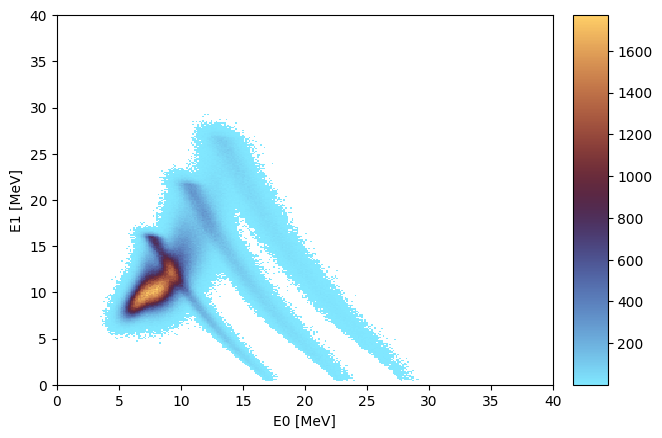

In [5]:
hdE01 = hist.Hist.new.Regular(300, 0, 40, label="E0 [MeV]").Regular(300, 0, 40, label="E1 [MeV]").Double()
hdE01.fill(dfs["dE0"], dfs["dE1"])

hdE01.plot(cmin=1, cmap="managua_r")

And its covariance matrix


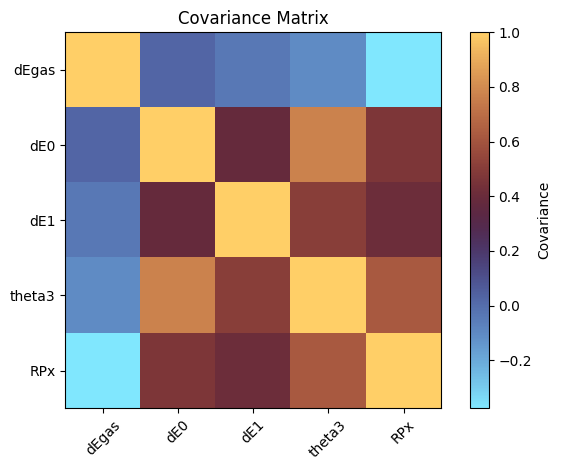

In [6]:
cov_matrix = dfs.drop(columns=["label", "T3", "T3After1"]).corr()

plt.imshow(cov_matrix, cmap='managua_r', interpolation='none')
plt.colorbar(label='Covariance')
plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns, rotation=45)
plt.yticks(range(len(cov_matrix.index)), cov_matrix.index)
plt.title('Covariance Matrix')
plt.tight_layout()

In [7]:
## Convert to numpy
X = dfs.drop(columns=["label", "T3", "T3After1"]).values
y = dfs["label"].values

# Encode str labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform((X))

### Defining the model

In [8]:
model = Sequential([
    Input(shape=(X_scaled.shape[1],)), 
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(len(encoder.classes_), activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

2025-05-02 15:14:47.330165: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,723 (26.26 KB)

 Trainable params: 6,723 (26.26 KB)

 Non-trainable params: 0 (0.00 B)

### Train and eval

In [9]:
early = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)
history = model.fit(X_scaled, y_encoded, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early])

Epoch 1/15
24487/24487 ━━━━━━━━━━━━━━━━━━━━ 24s 971us/step - accuracy: 0.8047 - loss: 0.4459 - val_accuracy: 0.8227 - val_loss: 0.4042
Epoch 2/15
24487/24487 ━━━━━━━━━━━━━━━━━━━━ 23s 956us/step - accuracy: 0.8224 - loss: 0.4043 - val_accuracy: 0.8240 - val_loss: 0.4004
Epoch 3/15
24487/24487 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.8239 - loss: 0.4015 - val_accuracy: 0.8241 - val_loss: 0.4014
Epoch 4/15
24487/24487 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - accuracy: 0.8244 - loss: 0.4011 - val_accuracy: 0.8253 - val_loss: 0.3992
Epoch 5/15
24487/24487 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.8244 - loss: 0.4001 - val_accuracy: 0.8257 - val_loss: 0.3978
Epoch 6/15
24487/24487 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.8251 - loss: 0.3995 - val_accuracy: 0.8251 - val_loss: 0.3986
Epoch 7/15
24487/24487 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.8251 - loss: 0.3993 - val_accuracy: 0.8261 - val_loss: 0.3971
Epoch 8/15
24487/24487 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accura

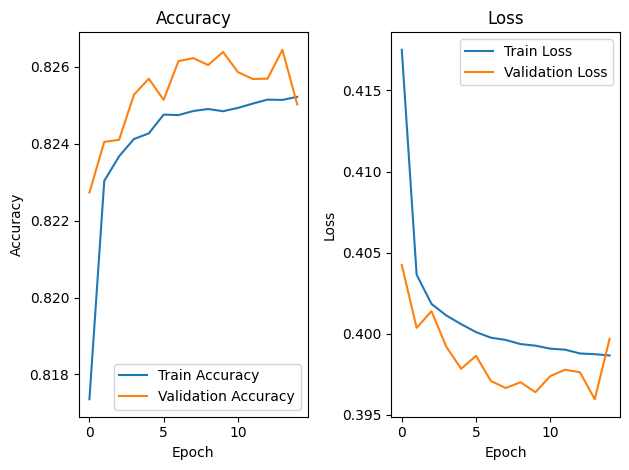

In [10]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

61217/61217 ━━━━━━━━━━━━━━━━━━━━ 31s 507us/step


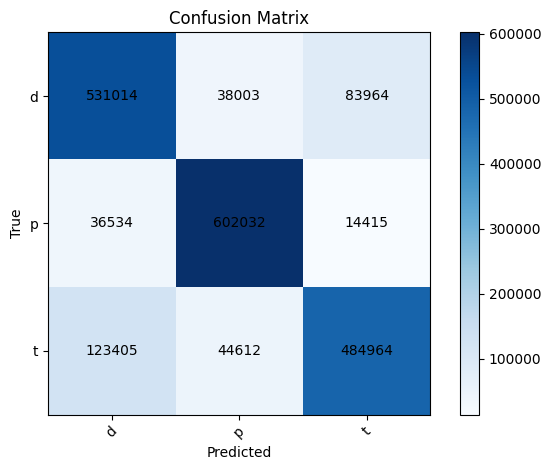

In [11]:
# Confusion matrix
y_pred = model.predict(X_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_encoded, y_pred_classes)

plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Add color bar
plt.colorbar()

# Annotate matrix with counts
classes = encoder.classes_
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Set ticks
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)

plt.tight_layout()

Which region is poorly reconstructed?

In [12]:
misclassified = (y_pred_classes != y_encoded)

df_mis = dfs[misclassified].copy()
df_mis["label_rec"] = encoder.inverse_transform(y_pred_classes[misclassified])
df_mis.head()

,dEgas,dE0,dE1,T3,theta3,RPx,T3After1,label,label_rec
2,0.263361,7.077109,8.616172,57.498722,9.044887,77.945279,41.534294,t,p
3,0.204617,7.393320,8.956724,27.211260,8.211050,127.483629,10.662347,p,d
14,0.067983,8.689047,11.359770,35.245841,21.067864,184.153283,15.054205,d,t
23,0.209546,10.612734,13.299814,50.833843,20.163800,135.893312,26.647885,t,d
30,0.204869,8.161322,9.742312,57.348309,9.266338,97.380664,39.237450,t,d


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x751e1bd26a10>, cbar=None, text=[])

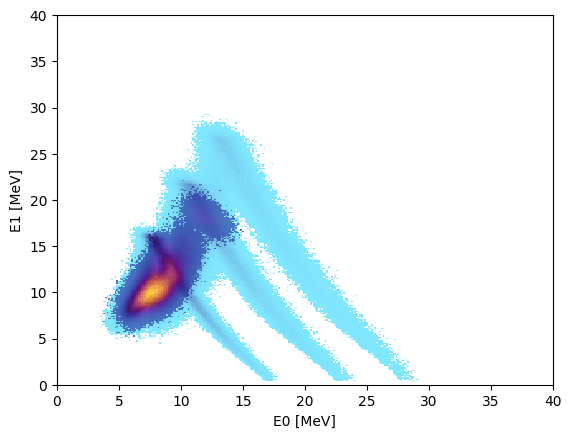

In [15]:
hdE01Mis = hdE01.copy()
hdE01Mis.reset()
hdE01Mis.fill(df_mis["dE0"], df_mis["dE1"])

hdE01.plot(cmin = 1, cmap="managua_r", cbar=None)
hdE01Mis.plot(cmin = 1, cmap="plasma", alpha=0.5, cbar=None)

So it seems it is really complicated to separate particles with this method: the NN won't do anything we cannot separate by hand: $\theta$ is a free parameter that allows the event to be either (d,p), (d,d) or (d,t) by changing Ex.

## Kinematical separation

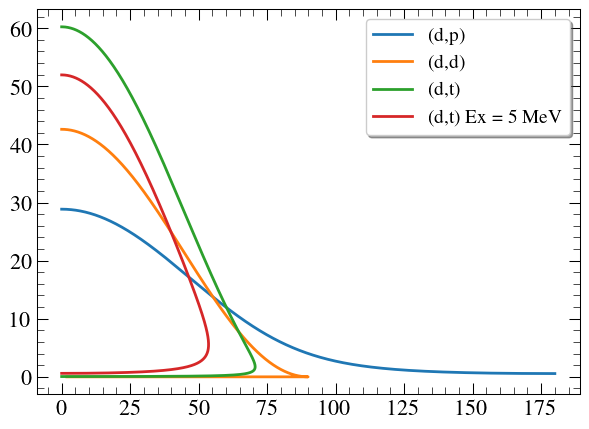

In [26]:
for r in ["(d,p)", "(d,d)", "(d,t)"]:
    kin = phys.KinInterface(f"11Li{r}@81.5")
    kin.plot_kin3(lw=2, label=r)
phys.KinInterface("11Li(d,t)@81.5|5").plot_kin3(lw=2, label="(d,t) Ex = 5 MeV")
plt.legend(fontsize=14)

So reconstruction event-by-event the Elab assuming either p, d or t and checking which events fall within the kinematical boundaries would be fine.